In [ ]:
from dataclasses import dataclass, field
from pathlib import Path
import os

os.environ['LANDSLIDE_DENSITY_THRESHOLD'] = (
    '0.0000001'  # the percentage landslide required for an image to be classified as landslided (check landnet.config module)
)

from pytorch_grad_cam import (
    GradCAM,
    HiResCAM,
    ScoreCAM,
    GradCAMPlusPlus,
    AblationCAM,
    XGradCAM,
    EigenCAM,
    RandomCAM,
    LayerCAM,
    GradCAMElementWise,
    EigenGradCAM,
    GuidedBackpropReLUModel,
)
from pytorch_grad_cam.guided_backprop import GuidedBackpropReLUasModule
from pytorch_grad_cam.utils.image import (
    show_cam_on_image,
    deprocess_image,
    preprocess_image,
)
from pytorch_grad_cam.utils.find_layers import replace_all_layer_type_recursive
from pytorch_grad_cam.utils.model_targets import (
    BinaryClassifierOutputTarget,
    ClassifierOutputTarget,
)
from pytorch_grad_cam.metrics.road import ROADCombined
from torch import nn
import torch
import numpy as np
import cv2
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from IPython.display import clear_output
from sklearn.decomposition import PCA

from landnet.config import MODELS_DIR, FIGURES_DIR
from landnet.enums import Mode, GeomorphometricalVariable, Architecture
from landnet.modelling import torch_clear
from landnet.modelling.classification.lightning import LandslideImageClassifier
from landnet.modelling.classification.models import get_architecture
from landnet.modelling.classification.dataset import (
    ConcatLandslideImageClassification,
    LandslideImageClassification,
)
from landnet.features.grids import get_grid_for_variable, Grid
from landnet.features.tiles import TileConfig, TileSize
from landnet.modelling.dataset import get_default_transform
from landnet.typing import TuneSpace

clear_output()

In [ ]:
tile_config = TileConfig(TileSize(100, 100), overlap=0)
model_config: TuneSpace = {
    'batch_size': 1,
    'learning_rate': 0.000001,
    'tile_config': tile_config,
}


@dataclass
class Model:
    checkpoint_path: Path
    name: str
    variables: list[GeomorphometricalVariable] = field(init=False)
    grids: dict[Mode, list[Grid]] = field(init=False, default_factory=dict)
    datasets: dict[Mode, list[tuple[torch.Tensor, torch.Tensor]]] = field(
        init=False, default_factory=dict
    )
    classifier: LandslideImageClassifier = field(init=False)
    is_setup: bool = field(init=False, default=False)

    def setup(self):
        assert self.checkpoint_path.exists()
        variables_path = (
            self.checkpoint_path.parent.parent.parent
            / 'geomorphometrical_variables'
        )
        assert variables_path.exists()
        self.variables = GeomorphometricalVariable.parse_file(variables_path)
        self.set_classifier()
        self.get_grids_and_datasets()
        clear_output()
        self.is_setup = True

    def set_classifier(self):
        self.classifier = LandslideImageClassifier.load_from_checkpoint(
            self.checkpoint_path,
            model=get_architecture(Architecture('convnext'))(
                len(self.variables), Mode.INFERENCE
            ),
        )

    def get_grids_and_datasets(self):
        for mode in (Mode.TEST,):
            self.grids[mode] = [
                get_grid_for_variable(
                    variable,
                    tile_config=tile_config,
                    mode=mode,
                )
                for variable in self.variables
            ]
            dataset = ConcatLandslideImageClassification(
                landslide_images=[
                    LandslideImageClassification(
                        grid,
                        mode,
                        transform=get_default_transform(),
                    )
                    for grid in self.grids[mode]
                ],
                augment_transform=None,
            )
            dataloader = DataLoader(
                dataset,
                batch_size=1,
                num_workers=4,
                shuffle=False,
                prefetch_factor=4,
                persistent_workers=True,
                pin_memory=True,
            )
            self.datasets[mode] = list(dataloader)


models = [
    Model(
        checkpoint_path=(
            MODELS_DIR
            / 'convnext_100x100_5vars/convnext_100x100_5vars/2025-06-27_16-46-08/TorchTrainer_05f6ed3b_2_batch_size=2,learning_rate=0.0000,tile_config=ref_ph_c793cfd2_2025-06-27_17-10-49/checkpoint_000008/checkpoint.ckpt'
        ),
        name='model 1',
    ),
    Model(
        checkpoint_path=(
            MODELS_DIR
            / 'convnext_100x100_10vars/convnext_100x100_10vars/TorchTrainer_cf20a57d_5_batch_size=4,learning_rate=0.0000,tile_config=ref_ph_c793cfd2_2025-06-28_00-30-26/checkpoint_000016/checkpoint.ckpt'
        ),
        name='model 2',
    ),
]

In [ ]:
def get_all_conv2d_layers(model):
    conv_layers = {}

    def recurse(module, prefix=''):
        for name, layer in module.named_children():
            full_name = f'{prefix}.{name}' if prefix else name
            if isinstance(layer, nn.Conv2d):
                conv_layers[full_name] = layer
            elif isinstance(layer, nn.Module):  # If it's a module, recurse
                recurse(layer, full_name)

    recurse(model)
    return conv_layers


def save_activations_and_gradients(
    cam, out_dir: Path, index: int = 0, count: int = 50, split: bool = True
):
    os.makedirs(out_dir, exist_ok=True)
    activations = cam.activations_and_grads.activations[index].squeeze(0)
    gradients = cam.activations_and_grads.gradients[index].squeeze(0)
    for matrices, name, cmap in zip(
        (activations, gradients),
        ('activations', 'gradients'),
        ('viridis', 'Grays'),
    ):
        num_channels = matrices.shape[0]
        num_arrs = min(count, num_channels)
        for i, matrix in enumerate(matrices):
            fig, ax = plt.subplots()
            if i > num_arrs:
                break
            arr = matrix.cpu().numpy()
            ax.imshow(arr, cmap=cmap)
            ax.axis('off')  # Hide axis
            plt.tight_layout()
            plt.savefig(
                out_dir / f'{name}_{i}_{matrix.shape}.png',
                dpi=300,
                transparent=True,
                bbox_inches='tight',
                pad_inches=0,
            )
            plt.close()


class BinaryGuidedBackpropReLUModel(GuidedBackpropReLUModel):
    def __init__(self, model, device):
        super().__init__(model, device)

    def __call__(self, input_img):
        replace_all_layer_type_recursive(
            self.model, nn.ReLU, GuidedBackpropReLUasModule()
        )

        input_img = input_img.to(self.device)

        input_img = input_img.requires_grad_(True)

        loss = self.forward(input_img)
        loss.backward(retain_graph=True)

        output = input_img.grad.cpu().data.numpy()
        output = output[0, :, :, :]
        output = output.transpose((1, 2, 0))

        replace_all_layer_type_recursive(
            self.model, GuidedBackpropReLUasModule, nn.ReLU()
        )

        return output


def get_guided_backprop(classifier, input_tensor, cam):
    gb_model = BinaryGuidedBackpropReLUModel(
        model=classifier, device=classifier.device
    )
    gb = gb_model(input_tensor)
    cam_mask = np.repeat(np.expand_dims(grayscale_cam, 2), gb.shape[2], 2)
    cam_gb = deprocess_image(cam_mask * gb)
    return cam_gb[:, :, :3]


class LogitBinaryClassifierOutputTarget:
    def __init__(self, category):
        self.category = category

    def __call__(self, model_output):
        model_output = model_output.sigmoid()
        if self.category == 1:
            sign = 1
        else:
            sign = -1
        return model_output * sign

DEBUG: Adapting model input channels from 10 to 3


ERROR: Failed to load the checkpoint at CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 5.92 GiB of which 39.75 MiB is free. Process 186440 has 2.35 GiB memory in use. Process 211915 has 1.38 GiB memory in use. Including non-PyTorch memory, this process has 1.42 GiB memory in use. Of the allocated memory 1.33 GiB is allocated by PyTorch, and 7.72 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables) with /media/alex/alex/python-modules-packages-utils/landnet/models/convnext_100x100_10vars/convnext_100x100_10vars/TorchTrainer_cf20a57d_5_batch_size=4,learning_rate=0.0000,tile_config=ref_ph_c793cfd2_2025-06-28_00-30-26/checkpoint_000016/checkpoint.ckpt. Attempting the legacy way.


ValueError: Will not attempt reading the checkpoint in a legacy way.

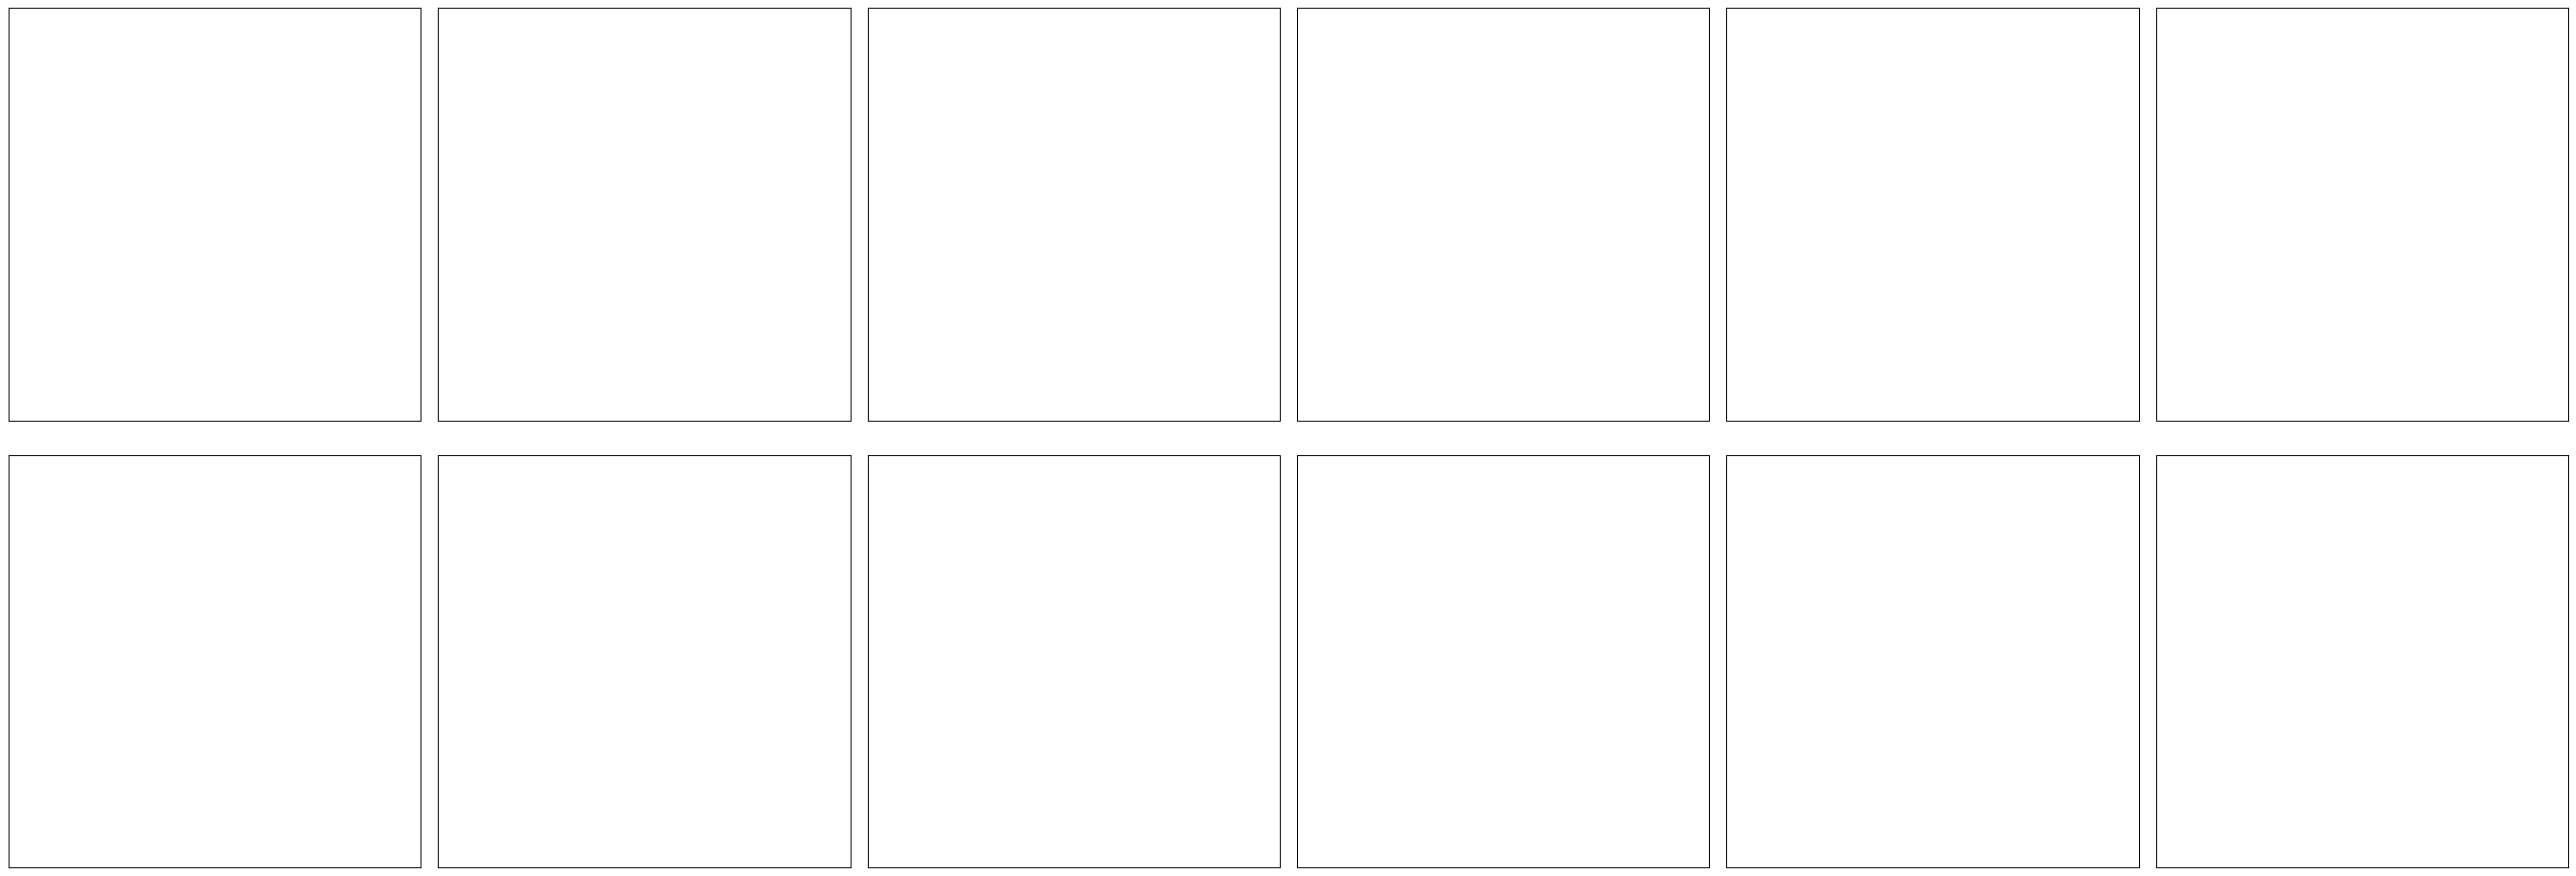

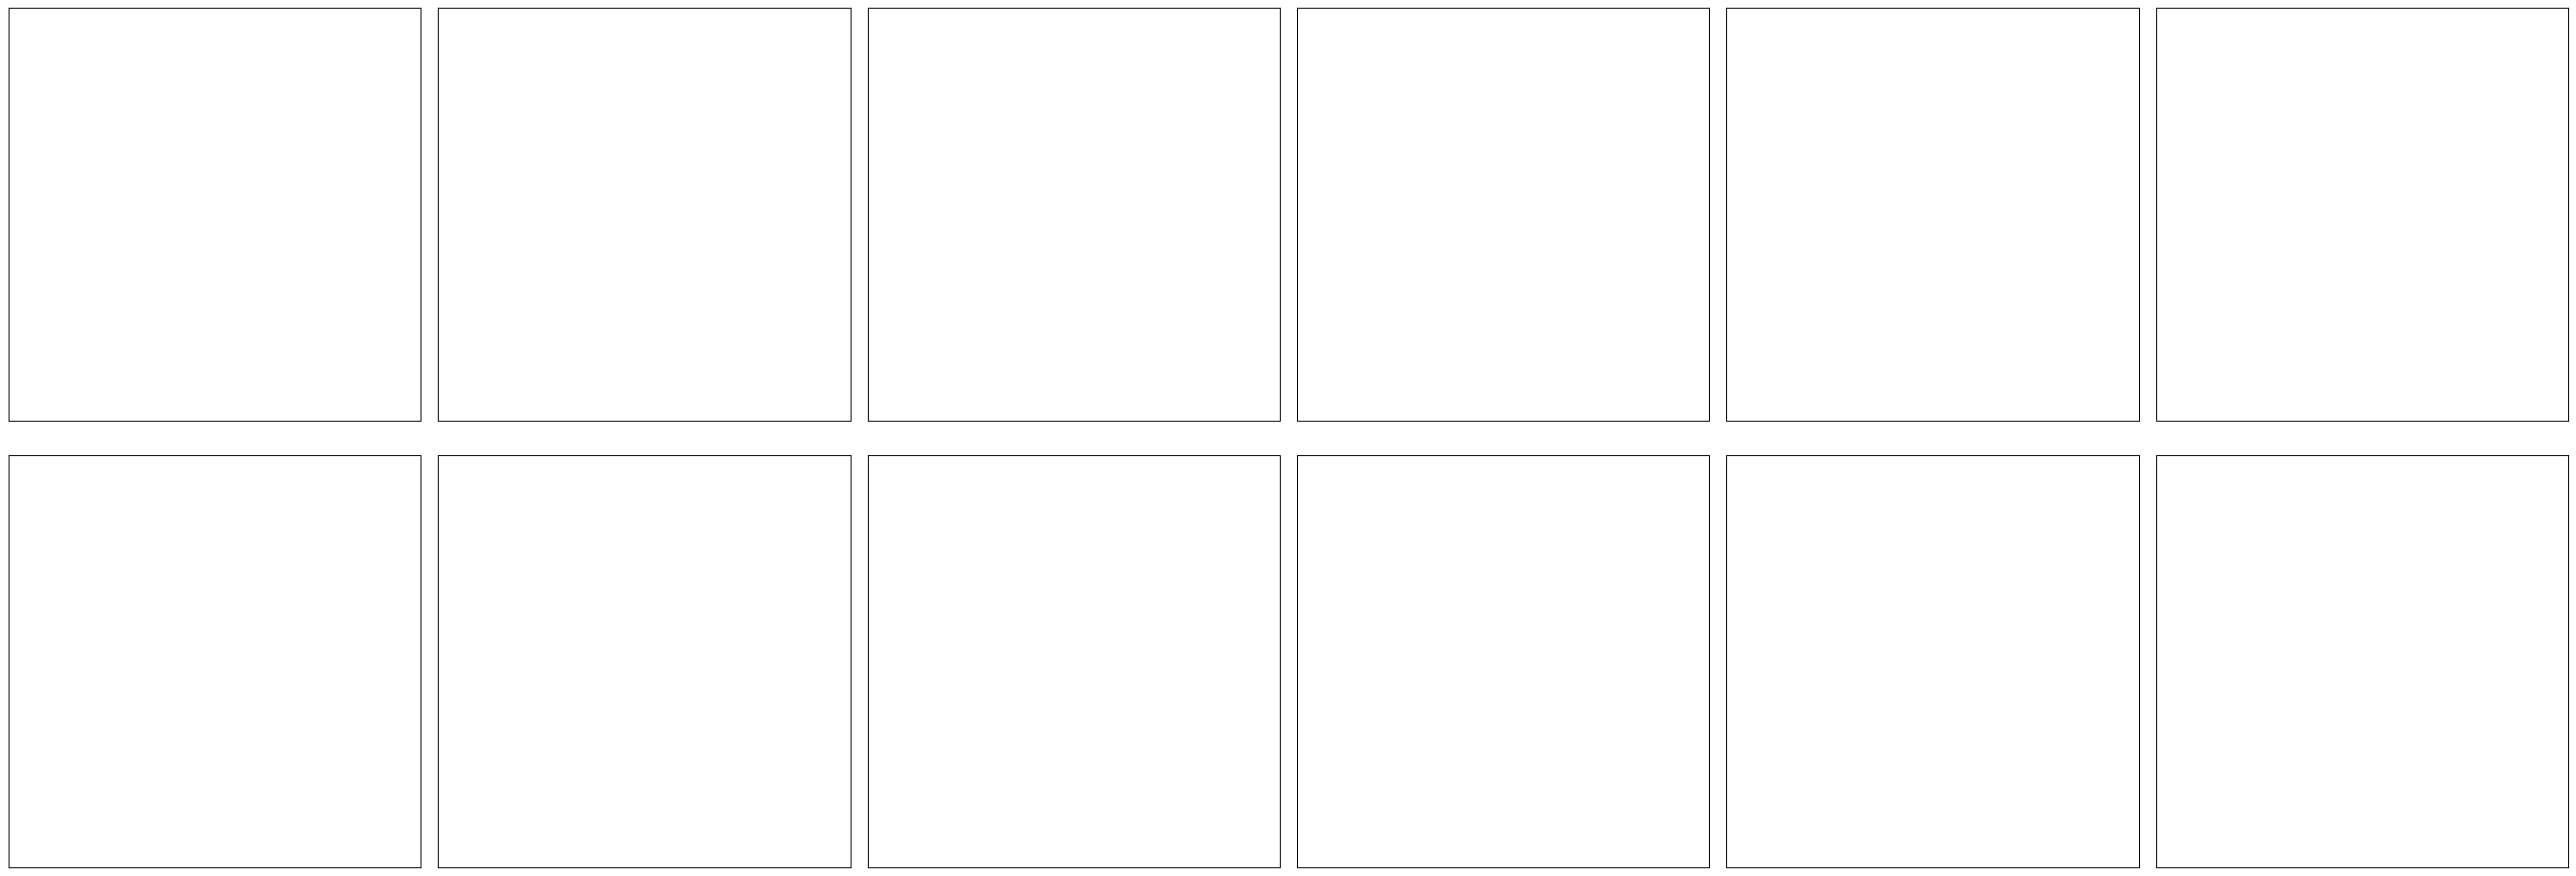

In [ ]:
# Compares different GradCAM methods

# The index of the tiles to select from the test area

# Good examples
# sample_indices = [297, 265, 392, 360, 241, 164, 90, 357]

# Low landslide density
sample_indices = [156, 5, 271, 317, 359, 194, 292, 231, 339, 174, 232, 286]

# False negatives
# sample_indices = [379, 293, 121, 329, 363, 342]
n_samples = len(sample_indices)
n_models = len(models)

grid_fig = plt.figure(figsize=(30.0, 30.0))
grid_fig.set_tight_layout(True)
guided_backprop_fig = plt.figure(figsize=(30.0, 30.0))
guided_backprop_fig.set_tight_layout(True)

nrows = n_models + 1
ncols = n_samples

guided_backprop_grid = ImageGrid(
    guided_backprop_fig,
    111,
    nrows_ncols=(nrows, ncols),
    axes_pad=(0.2, 0.4),
    share_all=True,
)
grid = ImageGrid(
    grid_fig,
    111,
    nrows_ncols=(nrows, ncols),
    axes_pad=(0.2, 0.4),
    share_all=True,
)
for grid_ in (guided_backprop_grid, grid):
    grid_[0].get_yaxis().set_ticks([])
    grid_[0].get_xaxis().set_ticks([])

fontdict = {'fontsize': 20}
cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
method = GradCAMPlusPlus

for i, model in enumerate(models, start=1):
    if not model.is_setup:
        model.setup()
    layers = get_all_conv2d_layers(model.classifier)
    layer_names = list(layers)
    layer_name = layer_names[-1]
    layer = layers[layer_name]
    target_layers = [layer]

    for j, sample_index in enumerate(sample_indices):
        cam_index = ncols * i + j
        sample = model.datasets[Mode.TEST][sample_index][0]
        hillshade = sample[0, 0].numpy()
        input_tensor = sample.to(model.classifier.device)
        if i == 1:
            grid[j].imshow(hillshade, cmap='binary')
            guided_backprop_grid[j].imshow(hillshade, cmap='binary')
            if j == 0:
                grid[j].set_ylabel(
                    'Hillshade',
                    fontdict=fontdict,
                    rotation='horizontal',
                    labelpad=80,
                )
                guided_backprop_grid[j].set_ylabel(
                    'Hillshade',
                    fontdict=fontdict,
                    rotation='horizontal',
                    labelpad=80,
                )
        if j == 0:
            grid[cam_index].set_ylabel(
                model.name,
                fontdict=fontdict,
                rotation='horizontal',
                labelpad=80,
            )
            guided_backprop_grid[cam_index].set_ylabel(
                model.name,
                fontdict=fontdict,
                rotation='horizontal',
                labelpad=80,
            )
        with method(model=model.classifier, target_layers=target_layers) as cam:
            targets = [LogitBinaryClassifierOutputTarget(1)]
            grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
            # save_activations_and_gradients(cam, out_dir=FIGURES_DIR / f'tile_{sample_index}' / layer_name)
            grayscale_cam = grayscale_cams[0, :]
            grid[cam_index].imshow(hillshade, cmap='binary')
            grid[cam_index].imshow(grayscale_cam, cmap='rainbow', alpha=0.5)
            guided_backprop_cam = get_guided_backprop(
                model.classifier, input_tensor, grayscale_cam
            )
            guided_backprop_grid[cam_index].imshow(
                guided_backprop_cam, cmap='rainbow'
            )

grid_fig.savefig(
    FIGURES_DIR / f'gradcams_comparison_{method.__name__}.png',
    dpi=300,
    bbox_inches='tight',
)
guided_backprop_fig.savefig(
    FIGURES_DIR / f'guidedbackpropcam_comparison_{method.__name__}.png',
    dpi=300,
    bbox_inches='tight',
)

/tmp/ipykernel_215790/523937177.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  grid_fig.savefig(FIGURES_DIR / f'false_negatives_gradcams_comparison_{method.__name__}.png', dpi=300, bbox_inches='tight')
/tmp/ipykernel_215790/523937177.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  guided_backprop_fig.savefig(FIGURES_DIR / f'false_negatives_guidedbackpropcam_comparison_{method.__name__}.png', dpi=300, bbox_inches='tight')


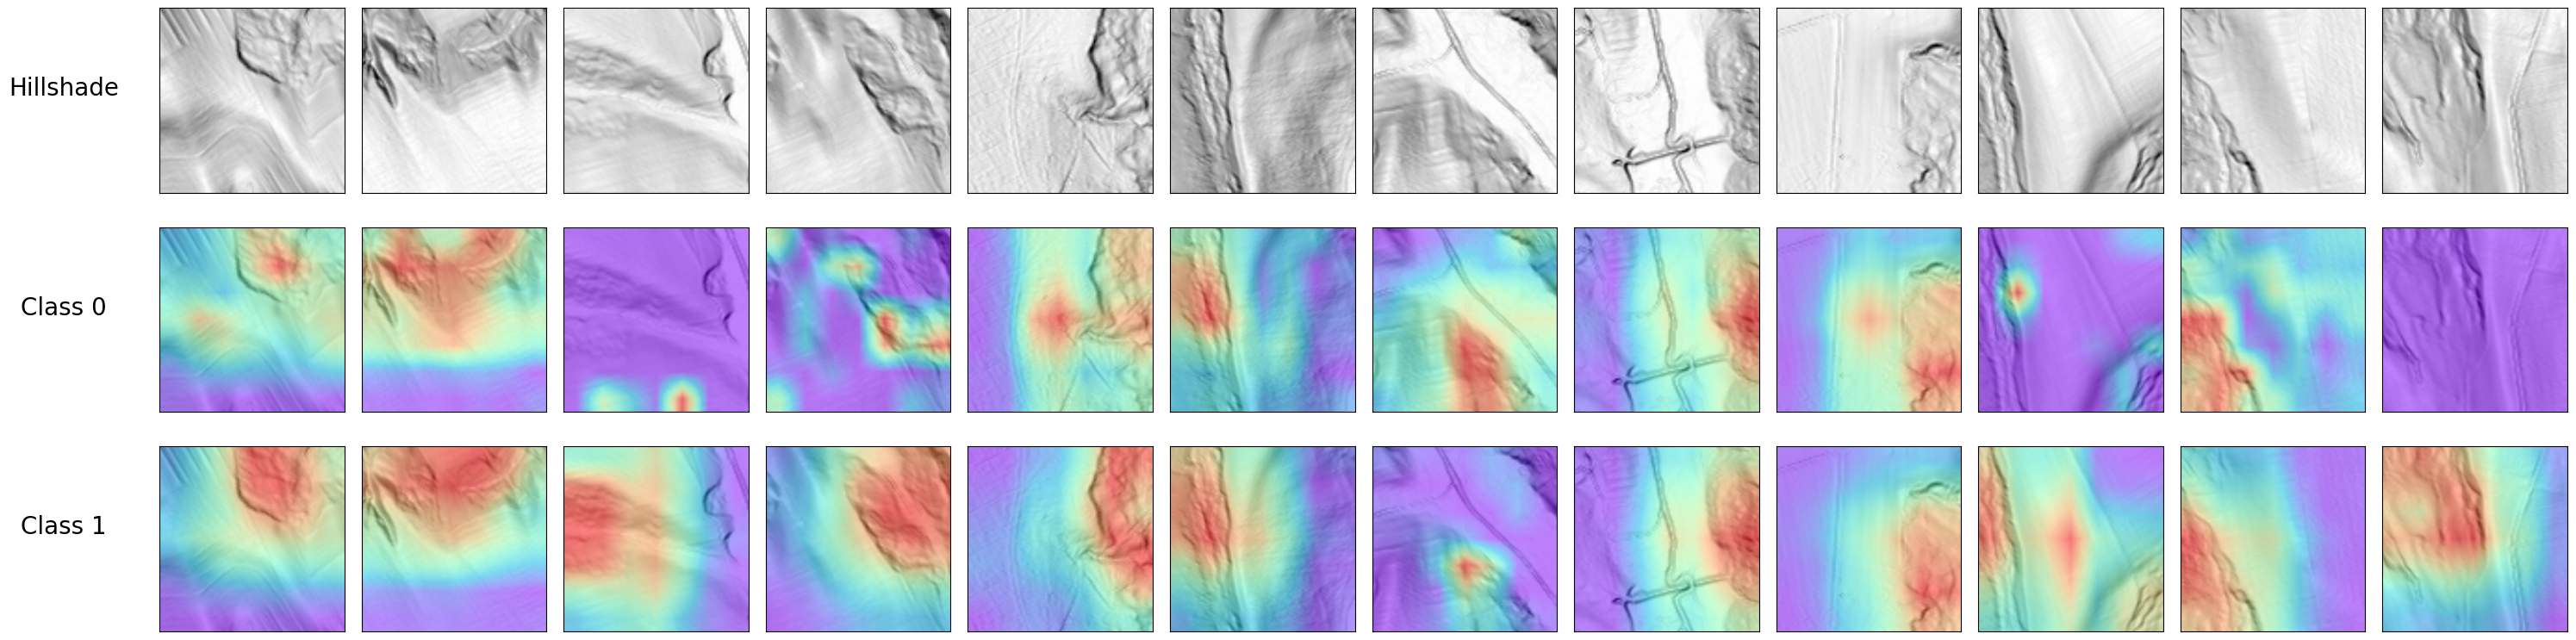

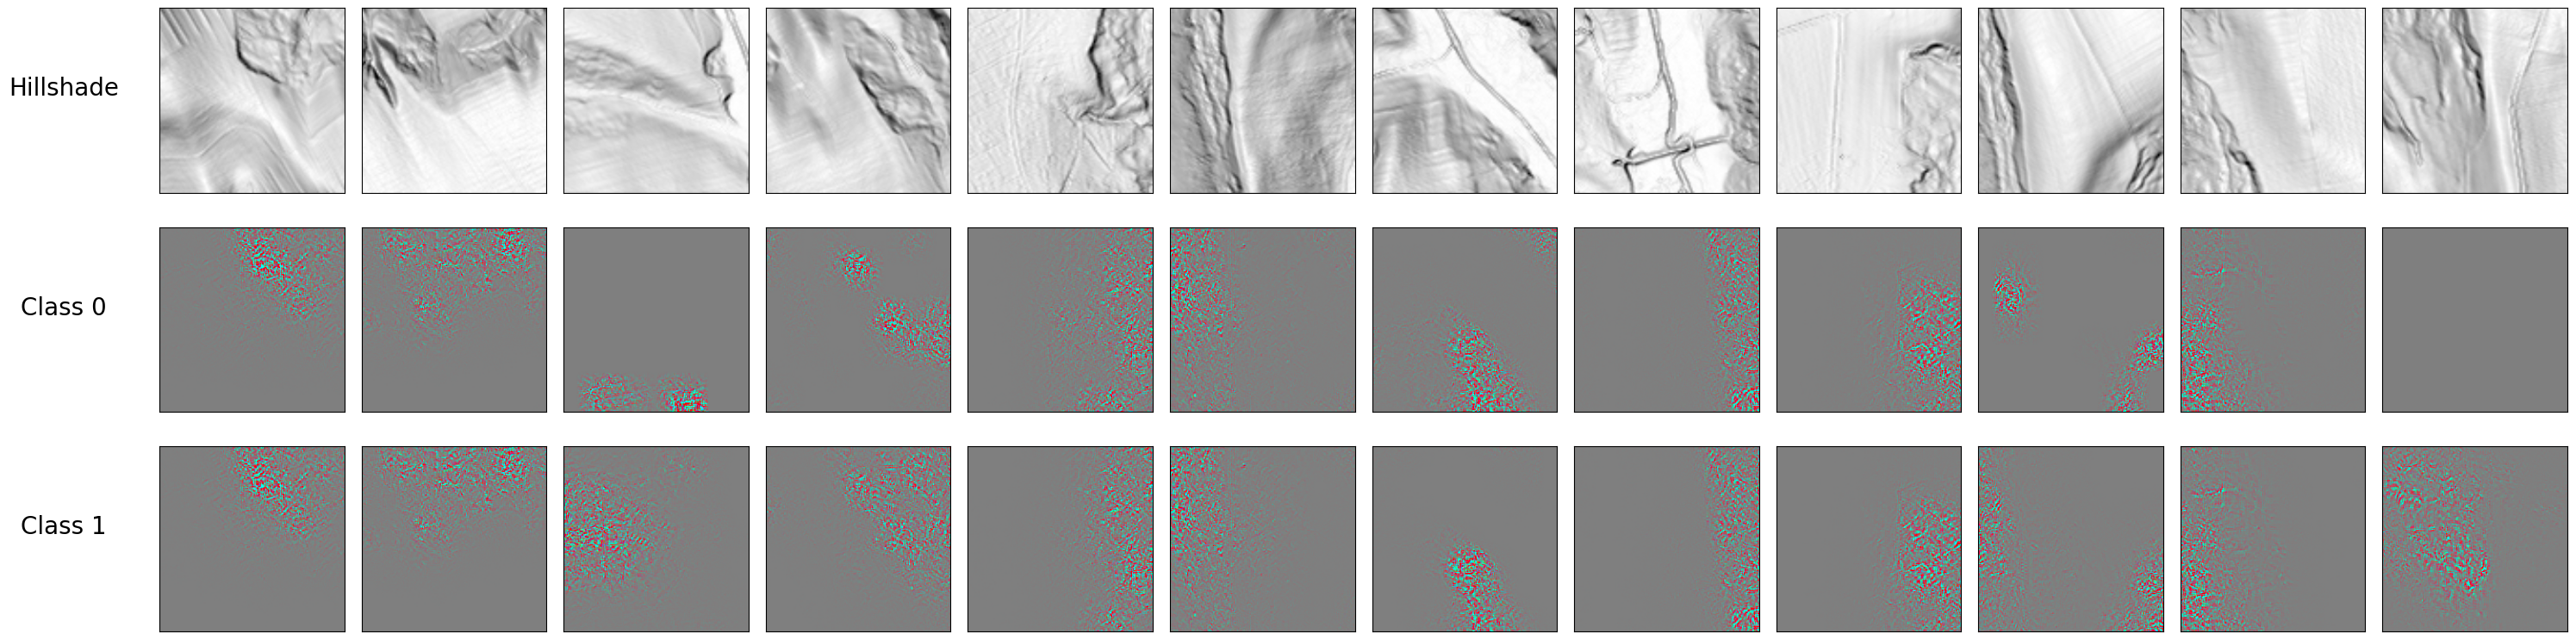

In [ ]:
# Compares different GradCAM methods

# The index of the tiles to select from the test area

# Good examples
# sample_indices = [297, 265, 392, 360, 241, 164, 90, 357]

# Low landslide density
sample_indices = [156, 5, 271, 317, 359, 194, 292, 231, 339, 174, 232, 286]

model = models[1]
classes = [0, 1]

# False negatives
# sample_indices = [379, 293, 121, 329, 363, 342]

n_samples = len(sample_indices)
n_classes = len(classes)

grid_fig = plt.figure(figsize=(30.0, 30.0))
grid_fig.set_tight_layout(True)
guided_backprop_fig = plt.figure(figsize=(30.0, 30.0))
guided_backprop_fig.set_tight_layout(True)

nrows = n_classes + 1
ncols = n_samples

guided_backprop_grid = ImageGrid(
    guided_backprop_fig,
    111,
    nrows_ncols=(nrows, ncols),
    axes_pad=(0.2, 0.4),
    share_all=True,
)
grid = ImageGrid(
    grid_fig,
    111,
    nrows_ncols=(nrows, ncols),
    axes_pad=(0.2, 0.4),
    share_all=True,
)
for grid_ in (guided_backprop_grid, grid):
    grid_[0].get_yaxis().set_ticks([])
    grid_[0].get_xaxis().set_ticks([])

fontdict = {'fontsize': 20}
cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
method = GradCAMPlusPlus

for i, class_ in enumerate(classes, start=1):
    if not model.is_setup:
        model.setup()
    layers = get_all_conv2d_layers(model.classifier)
    layer_names = list(layers)
    layer_name = layer_names[-1]
    layer = layers[layer_name]
    target_layers = [layer]

    for j, sample_index in enumerate(sample_indices):
        cam_index = ncols * i + j
        sample = model.datasets[Mode.TEST][sample_index][0]
        hillshade = sample[0, 0].numpy()
        input_tensor = sample.to(model.classifier.device)
        if i == 1:
            grid[j].imshow(hillshade, cmap='binary')
            guided_backprop_grid[j].imshow(hillshade, cmap='binary')
            if j == 0:
                grid[j].set_ylabel(
                    'Hillshade',
                    fontdict=fontdict,
                    rotation='horizontal',
                    labelpad=80,
                )
                guided_backprop_grid[j].set_ylabel(
                    'Hillshade',
                    fontdict=fontdict,
                    rotation='horizontal',
                    labelpad=80,
                )
        if j == 0:
            grid[cam_index].set_ylabel(
                f'Class {class_}',
                fontdict=fontdict,
                rotation='horizontal',
                labelpad=80,
            )
            guided_backprop_grid[cam_index].set_ylabel(
                f'Class {class_}',
                fontdict=fontdict,
                rotation='horizontal',
                labelpad=80,
            )
        with method(model=model.classifier, target_layers=target_layers) as cam:
            targets = [LogitBinaryClassifierOutputTarget(class_)]
            grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
            # save_activations_and_gradients(cam, out_dir=FIGURES_DIR / f'tile_{sample_index}' / layer_name)
            grayscale_cam = grayscale_cams[0, :]
            grid[cam_index].imshow(hillshade, cmap='binary')
            grid[cam_index].imshow(grayscale_cam, cmap='rainbow', alpha=0.5)
            guided_backprop_cam = get_guided_backprop(
                model.classifier, input_tensor, grayscale_cam
            )
            guided_backprop_grid[cam_index].imshow(
                guided_backprop_cam, cmap='rainbow'
            )

grid_fig.savefig(
    FIGURES_DIR / f'false_negatives_gradcams_comparison_{method.__name__}.png',
    dpi=300,
    bbox_inches='tight',
)
guided_backprop_fig.savefig(
    FIGURES_DIR
    / f'false_negatives_guidedbackpropcam_comparison_{method.__name__}.png',
    dpi=300,
    bbox_inches='tight',
)